In [1]:
import tqdm
import pickle
import warnings
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from meteostat import Point, Daily

from statsmodels.tsa.seasonal import STL

from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [2]:
sns.set()
pd.options.display.float_format = '{:,.2f}'.format

warnings.simplefilter("ignore")

### Загрузка и обработка данных

Устанавливаем 5-летний период времени для предсказания погоды. И устанавливаем локацию - координаты Санкт-Петербурга.

In [3]:
start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2023, 12, 31)

location = Point(59.938678, 30.314474)

In [4]:
data = Daily(location, start, end)
data = data.fetch()

In [5]:
data.head()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2019-01-01,-0.80,-2.50,1.10,3.50,170.00,179.00,18.60,44.50,996.20,NaN
2019-01-02,0.20,-1.80,1.60,3.50,140.00,160.00,10.50,25.90,994.60,NaN
2019-01-03,-3.10,-3.50,-1.80,1.30,150.00,12.00,17.40,29.60,"1,015.40",NaN
2019-01-04,-6.70,-6.90,-3.20,2.40,150.00,202.00,9.60,18.50,"1,014.40",NaN
2019-01-05,-5.10,-7.10,-3.60,0.70,170.00,56.00,8.10,18.50,"1,014.10",NaN


In [6]:
data.isna().sum()

tavg       0
tmin       0
tmax       0
prcp       5
snow    1452
wdir       5
wspd       0
wpgt       0
pres       0
tsun    1826
dtype: int64

Уберем всегда пустую колонку. Также уберем `tmin` и `tmax`, т.к. они сильно коррелируют с `tavg`.

In [7]:
data = data.drop(["tsun", "tmin", "tmax"], axis=1)

Заметим, что `NaN` в колонках `snow` и `prcp` соответствуют отсутствию осадков.

In [8]:
data["snow"] = data["snow"].fillna(0)
data["prcp"] = data["prcp"].fillna(0)

Учитывая небольшое количество пропусков для направления ветра `wdir` заполним значения предыдущим днем.

In [9]:
data["wdir"] = data["wdir"].bfill()

In [10]:
data.mean()

tavg       6.78
prcp       1.78
snow      30.99
wdir     199.11
wspd      12.02
wpgt      26.56
pres   1,012.01
dtype: float64

Общая функция для препроцессинга:

In [11]:
def preprocess_data(data):
    data = data.drop(["tsun", "tmin", "tmax"], axis=1)
    data["snow"] = data["snow"].fillna(0)
    data["prcp"] = data["prcp"].fillna(0)
    # пытаемся заполнить данными, которые есть, иначе берем среднее по датасету
    data["wdir"] = data["wdir"].bfill().ffill().fillna(200)
    return data

### Анализ данных

Теперь визуализируем данные.

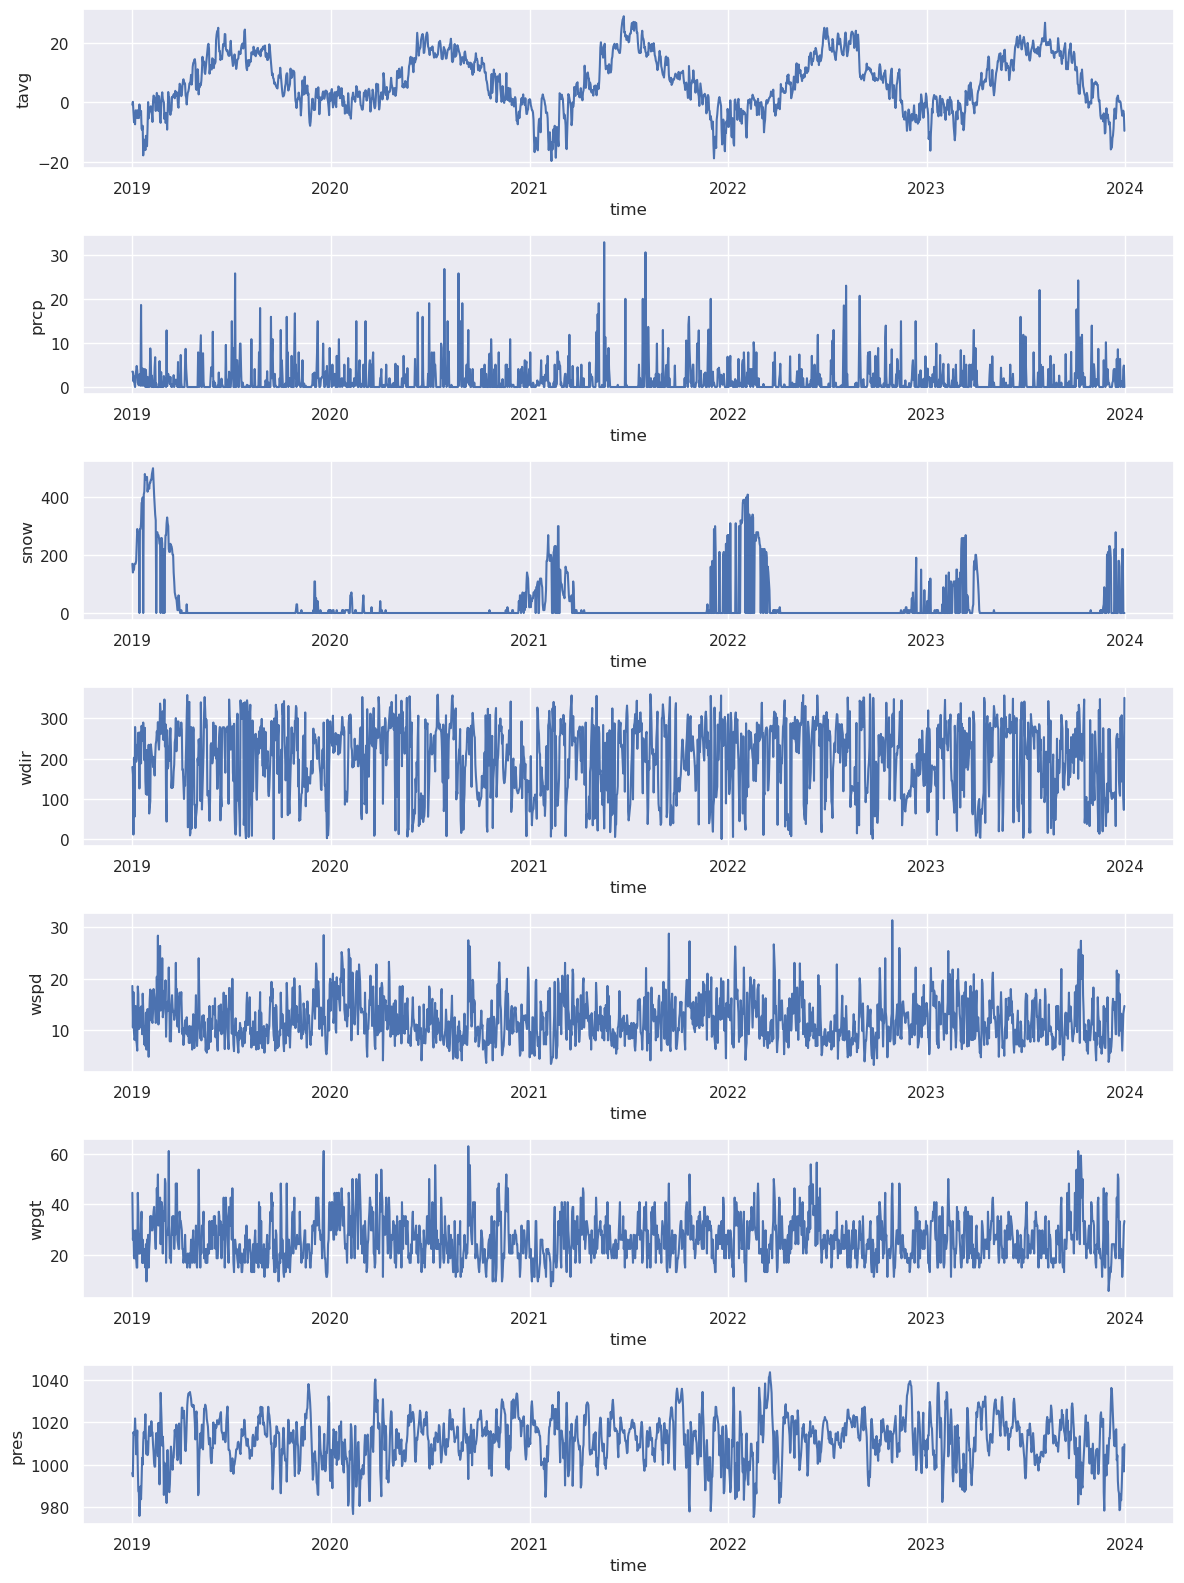

In [12]:
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(12, 16))

for i, column in enumerate(data.columns):
    sns.lineplot(ax=axes[i], data=data[column])

plt.tight_layout()
plt.show()

Теперь посмотрим на корреляции между данными.

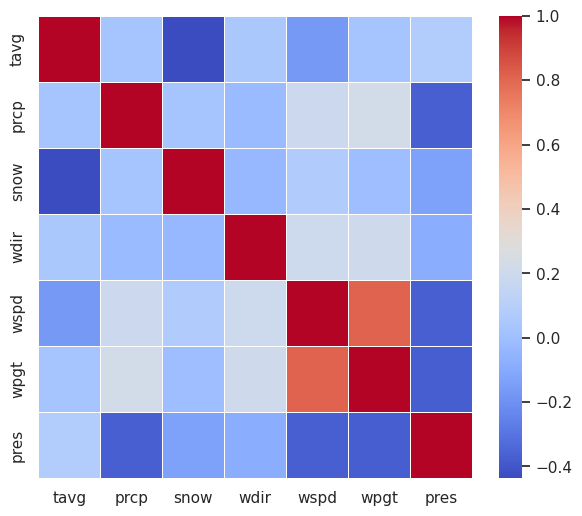

In [13]:
plt.figure(figsize=(7, 6))
sns.heatmap(data.corr(), cmap='coolwarm', linewidths=.5)
plt.show()

Посмотрим, как температура разбивается на компоненты, как временной ряд:

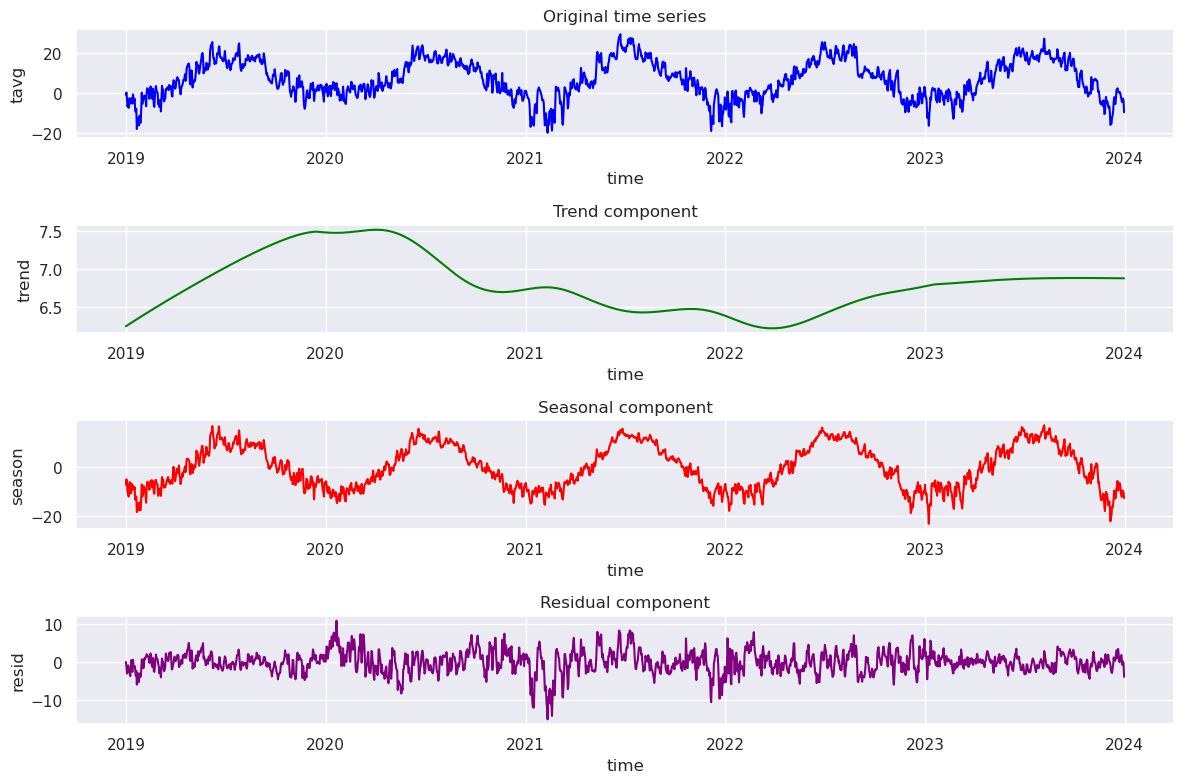

In [14]:
stl = STL(data["tavg"], period=365)
result = stl.fit()

plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
sns.lineplot(data["tavg"], color='blue')
plt.title('Original time series')

plt.subplot(4, 1, 2)
sns.lineplot(result.trend, color='green')
plt.title('Trend component')

plt.subplot(4, 1, 3)
sns.lineplot(result.seasonal, color='red')
plt.title('Seasonal component')

plt.subplot(4, 1, 4)
sns.lineplot(result.resid, color='purple')
plt.title('Residual component')

plt.tight_layout()
plt.show()

### Обучение модели

В качестве тестового датасета будем использовать данные за последний год.

In [15]:
data_train = data[:-365]
data_test = data[-365:]

#### Реализация гибридной, рекурсивной и прямой стратегии

In [16]:
def extract_features(data: pd.DataFrame, model_idx: int, window_size: int = 3, mode: str = "hybrid"):
    if mode == "hybrid":
        feature_window = window_size + model_idx
        data = data[-feature_window:]
    elif mode == "recursive":
        feature_window = window_size
        data = data[-feature_window:]
    elif mode == "direct":
        feature_window = window_size
        data = data[-feature_window:]["tavg"]
        
    values = data.values.reshape(-1)
    date = data.index[-1] + datetime.timedelta(days=1 + model_idx)
    day = (date - start).days
    month = date.month
    return np.concatenate([values, [day, month]])

In [17]:
def build_datasets(data: pd.DataFrame, window_size: int = 3, model_count: int = 3, mode: str = "hybrid"):
    datasets = []
    n = len(data)
        
    for i in range(model_count):  
        features = np.array([extract_features(data[:j], i, window_size, mode) for j in range(window_size + i, n)])
        targets = data[window_size + i:]
        if mode == "direct":
            targets = targets["tavg"]
        datasets.append((features, targets.values))

    return datasets

In [18]:
def train_models(data: pd.DataFrame, model_type, model_kwargs, model_count: int = 3, window_size: int = 3, mode: str = "hybrid"):
    models = []

    if mode == "recursive":
        dataset = build_datasets(data, window_size, 1, mode)[0]
        model = MultiOutputRegressor(model_type(**model_kwargs))
        model.fit(*dataset)
        return [model] * model_count

    datasets = build_datasets(data, window_size, model_count, mode)
    
    for i in range(model_count):
        if mode == "direct":
            model = model_type(**model_kwargs)
        elif mode == "hybrid":
            model = MultiOutputRegressor(model_type(**model_kwargs))
        model.fit(*datasets[i])
        models.append(model)

    return models

In [19]:
def predict(data: pd.DataFrame, models, window_size: int = 3, mode: str = "hybrid"):    
    last_date = data.index[-1]
    predictions = pd.Series()
    
    for i, model in enumerate(models):
        features = extract_features(data, i, window_size, mode).reshape(1, -1)
        last_date += datetime.timedelta(days=1)
        if mode == "direct":
            prediction = pd.Series([model.predict(features)], index=[last_date])
            predictions = pd.concat([predictions, prediction], axis=0)
        else:
            prediction = pd.DataFrame(model.predict(features), index=[last_date], columns=data.columns)
            data = pd.concat([data, prediction], axis=0)
            predictions = pd.concat([predictions, prediction["tavg"]], axis=0)

    return predictions

In [20]:
def score_models(data_test, models, window_size: int = 3, mode: str = "hybrid"):
    input_size = len(data_test)
    predict_size = len(models)

    n_predictions = input_size - window_size - predict_size + 1
    predictions = np.zeros((n_predictions, predict_size))
    targets = np.zeros((n_predictions, predict_size))

    for i in range(n_predictions):
        predictions[i] = predict(data_test[:window_size + i], models, window_size, mode).values
        targets[i] = data_test[window_size + i:window_size + predict_size + i]["tavg"].values

    return np.mean(np.abs(targets - predictions), axis=0)

In [64]:
window_size = 15
predict_size = 15

modes = ["direct", "recursive", "hybrid"]
estimators = {"Gradient boosting": (CatBoostRegressor, {"verbose": 0}), 
              "Linear regression": (LinearRegression, {})}

result_models = {}
result_scores = {}

bar = tqdm.tqdm(range(len(modes) * len(estimators)), desc="Training")

for mode in modes:
    result_models[mode] = {}
    result_scores[mode] = {}
    for estimator_name, (estimator, params) in estimators.items():
        models = train_models(data_train, estimator, params, predict_size, window_size, mode)
        result_models[mode][estimator_name] = models
        scores = score_models(data_test, models, window_size, mode)
        result_scores[mode][estimator_name] = scores
        bar.update()


Training: 100%|████████████████████████████████| 9/9 [1:01:57<00:00, 413.01s/it]


KeyboardInterrupt: 

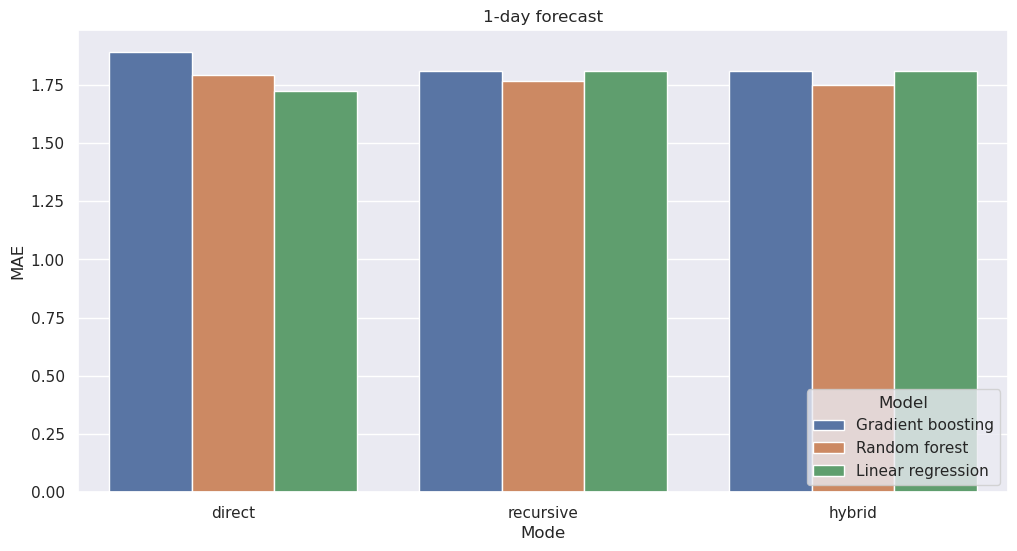

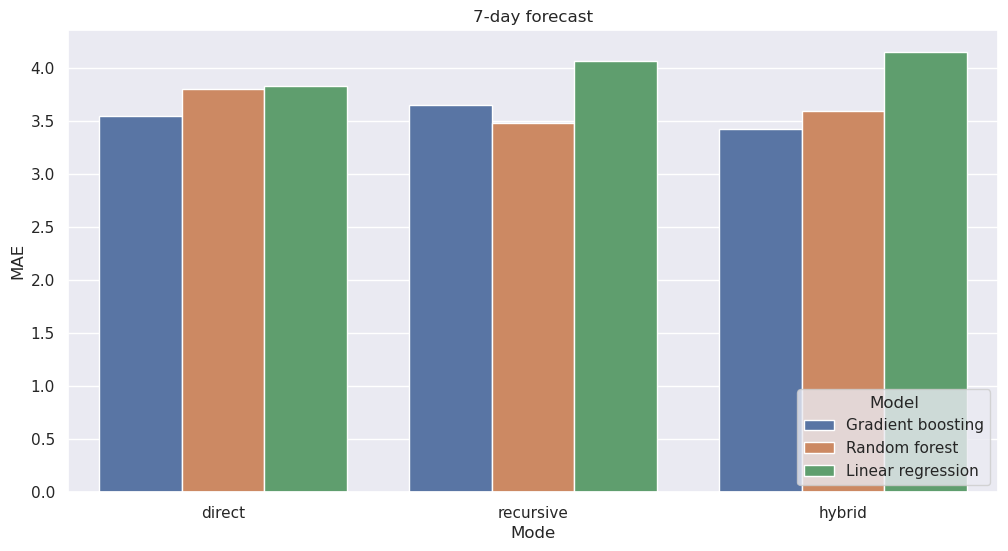

In [51]:
rows = []
for train_mode, models in result_scores.items():
    for model, values in models.items():
        rows.append([train_mode, model, values[0], values[6]])

df = pd.DataFrame(rows, columns=['train_mode', 'model', 'value1', 'value7'])

plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='train_mode', y='value1', hue='model', dodge=True)
plt.title('1-day forecast')
plt.xlabel('Mode')
plt.ylabel('MAE')
plt.legend(title='Model', loc="lower right")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='train_mode', y='value7', hue='model', dodge=True)
plt.title('7-day forecast')
plt.xlabel('Mode')
plt.ylabel('MAE')
plt.legend(title='Model', loc="lower right")
plt.show()

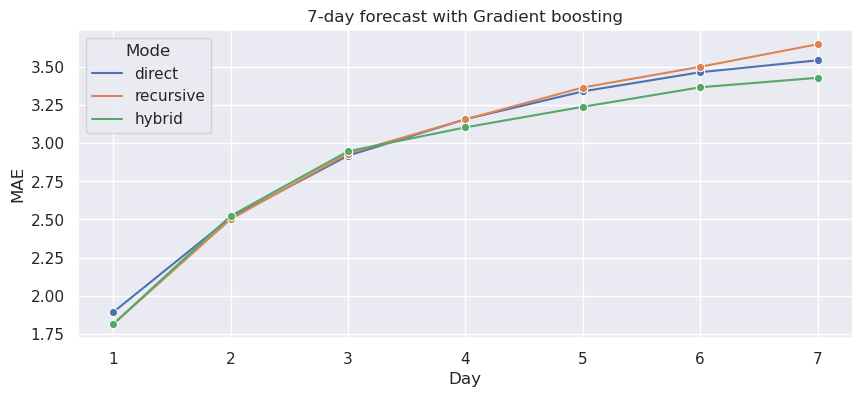

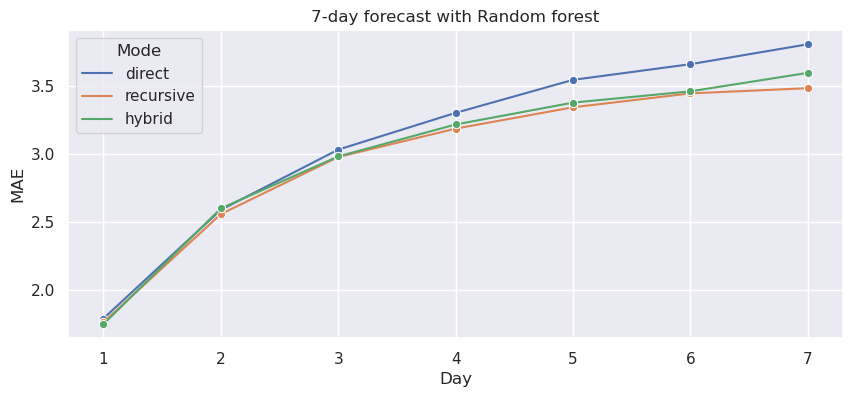

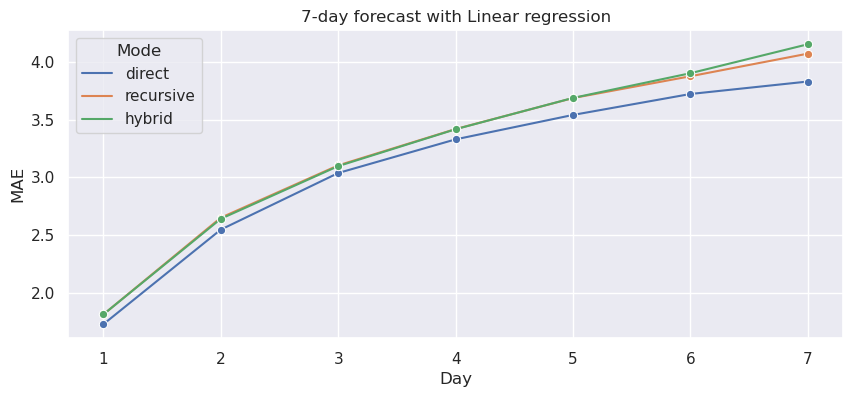

In [63]:
for model_name in estimators:
    rows = []
    for train_mode, models in result_scores.items():
        if model_name in models:
            values = models[model_name]
            rows.append([train_mode] + list(values))
    
    columns = ['train_mode'] + [f'value_{i}' for i in range(1, 8)]
    df = pd.DataFrame(rows, columns=columns)
    
    df_melted = df.melt(id_vars='train_mode', var_name='value_index', value_name='value')
    df_melted['value_index'] = df_melted['value_index'].str.extract('(\d+)').astype(int)
    
    plt.figure(figsize=(10, 4))
    sns.lineplot(data=df_melted, x='value_index', y='value', hue='train_mode', marker='o')
    plt.title(f'7-day forecast with {model_name}')
    plt.xlabel('Day')
    plt.ylabel('MAE')
    plt.legend(title='Mode')
    plt.show()

### Сохранение модели

In [ ]:
with open("model.pkl", "wb") as file:
    pickle.dump(models, file)

In [ ]:
with open("model.pkl", "rb") as file:
    models = pickle.load(file)

In [ ]:
predict(data_test, models, window_size)